In [128]:
%pylab inline
import pandas as pd
import libaarhusxyz
import numpy as np
import SimPEG.electromagnetics.utils.static_instrument.dual

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/redhog/Projects/Emerald/experimental-pipeline-inversion/env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['inv']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Data preparation

Download data from https://purl.stanford.edu/vj301kx0276 and place it in the folder data/IncisedValley.

As this data is not in the original SkyTEM XYZ format, but has been converted to a CSV (the header has been stripped) we need to convert it back to that format. We also extract a single
flightlines so that the inversion in this example notebook doesn't take forever to run :)

In [43]:
x = libaarhusxyz.XYZ()
x.flightlines = pd.read_csv("data/IncisedValley/aem_processed_data_foothill_central_valley.csv")
x.model_info["scalefactor"] = 1e12
x.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.xyz")

x = libaarhusxyz.XYZ("data/IncisedValley/aem_processed_data_foothill_central_valley.xyz", normalize=True)
filt = x.flightlines.title == 302701.0
x.flightlines = x.flightlines.loc[filt].reset_index(drop=True)
for key, value in x.layer_data.items():
    x.layer_data[key] = value.loc[filt].reset_index(drop=True)

x.dump("data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz")


# Inversion

Load the data int RAM, prepare a calibrated system description, invert the data and plot the result

In [297]:
measured = libaarhusxyz.XYZ("data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz", normalize=True)
gex = libaarhusxyz.GEX("data/IncisedValley/aem_processed_data_foothill_central_valley.gex")

header [General] parsed
header [Channel1] parsed
header [Channel2] parsed


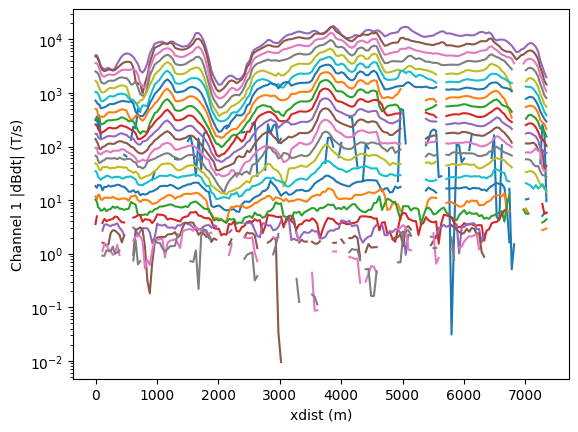

In [303]:
measured.plot()

In [299]:
for k in ["dbdt_ch1gt", "dbdt_ch2gt"]:
    measured.layer_data[k] = pd.DataFrame(np.where(measured.layer_data[k].values > 0,
                                                   measured.layer_data[k].values * 1e12,
                                                   np.nan),
                                          columns = measured.layer_data[k].columns,
                                          index=measured.layer_data[k].index)
measured.model_info["scalefactor"] = 1e-12
measured.flightlines.tilt_x -= 270 # 0 degrees should be when frame is horizontal
measured.flightlines.tilt_y -= 270

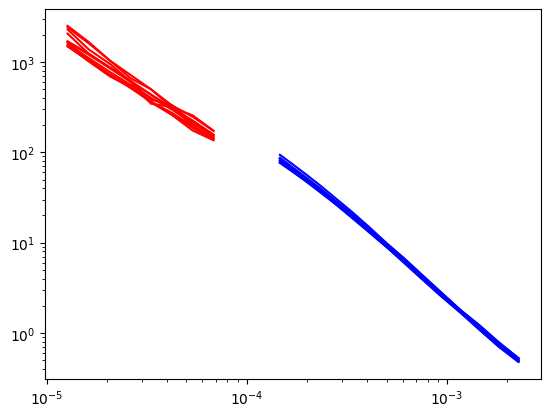

In [300]:
CalibratedSystem = SimPEG.electromagnetics.utils.static_instrument.dual.DualMomentTEMXYZSystem.load_gex(gex)
inv = CalibratedSystem(
    measured,
    gate_filter__start_lm=7,
    gate_filter__end_lm=15,
    gate_filter__start_hm=15,
    gate_filter__end_hm=30,
)

for row in range(0, 10):
    plt.loglog(inv.times[1], inv.xyz.layer_data["dbdt_ch2gt"].iloc[row], color="blue")
    plt.loglog(inv.times[0], inv.xyz.layer_data["dbdt_ch1gt"].iloc[row], color="red")
    #plt.show()

In [301]:
inv.invert()

Using default (spLU) solver


/home/redhog/Projects/Emerald/experimental-pipeline-inversion/env/lib/python3.9/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh._cellGradStencil has been deprecated, please use TensorMesh.stencil_cell_gradient. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.42e+01  2.35e+05  0.00e+00  2.35e+05    8.64e+03      0              

                Default solver: SolverDiag is being used in bfgsH0
                
   1  7.10e+00  3.94e+04  1.49e+03  4.99e+04    8.61e+03      0              
   2  3.55e+00  6.76e+03  1.38e+03  1.17e+04    1.08e+03      0              
   3  1.78e+00  4.04e+03  1.54e+03  6.77e+03    7.01e+02      0   Skip BFGS  
   4  8.88e-01  2.90e+03  1.91e+03  4.60e+03    4.28e+02      0   Skip BFGS  
   5  4.44e-01  2.18e+03  2.45e+03  3.27e+03    2.65e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.3475e+04
1 : |xc-x_last| = 4.6995e+00 <= tolX*(1+|x0|) = 3.4128e+01

/home/redhog/Projects/Emerald/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:493: RuntimeWarning: divide by zero encountered in divide
  std = np.abs(1 / self.inv.invProb.dmisfit.W.diagonal() / self.inv.invProb.dmisfit.data.dobs)
/home/redhog/Projects/Emerald/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:493: RuntimeWarning: divide by zero encountered in divide
  std = np.abs(1 / self.inv.invProb.dmisfit.W.diagonal() / self.inv.invProb.dmisfit.data.dobs)
/home/redhog/Projects/Emerald/simpeg/SimPEG/electromagnetics/utils/static_instrument/base.py:509: RuntimeWarning: invalid value encountered in divide
  xyzresp.flightlines['resdata'] = np.sqrt(np.nansum(derrall**2, axis=1) / (derrall > 0).sum(axis=1))


(None,
 data/IncisedValley/aem_processed_data_foothill_central_valley.302701.0.xyz
 --------------------------------
                                                                  0
 scalefactor                                                    0.0
 inversion_type                                                None
 naming_standard                                       libaarhusxyz
 projection                                                    None
 source           data/IncisedValley/aem_processed_data_foothill...
 
 Soundings: 182
 Columns: 18
 Flightlines: 1
 Maximum layer depth: 710.1203559062233
 Projection: None
             x          y
 min  275058.0  4055251.2
 max  280045.7  4060348.5
        Resistivity
 count  5460.000000
 mean     57.555843
 std      31.490510
 min       8.976666
 25%      27.275903
 50%      55.431084
 75%      90.867700
 max     129.469936
 
 Layer data: resistivity
 Layer params: layer, dep_top, dep_bot)

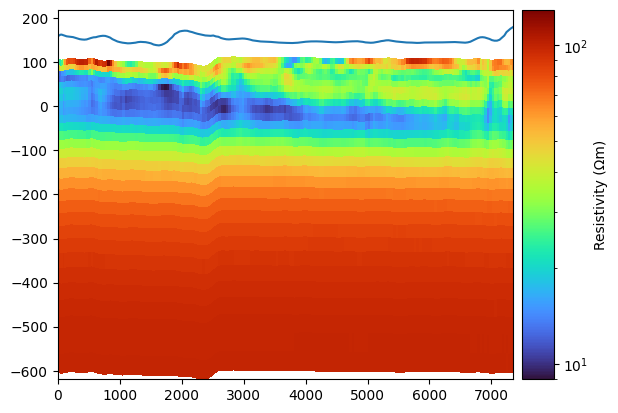

In [302]:
inv.l2.plot()

In [ ]:
fwd = CalibratedSystem(l2, times=inv.times)
l2data = fwd.forward()